In [0]:
# Load the dataset
dbutils.fs.mkdirs("/US_Healthcare/Hosp_Readmission_Reduction")

Out[1]: True

In [0]:
dbutils.fs.ls ("/US_Healthcare/Hosp_Readmission_Reduction")

Out[2]: []

In [0]:
dbutils.fs.ls ("dbfs:/US_Healthcare/")

Out[3]: [FileInfo(path='dbfs:/US_Healthcare/Hosp_Readmission_Reduction/', name='Hosp_Readmission_Reduction/', size=0, modificationTime=0)]

In [0]:
from pyspark.sql.functions import *

In [0]:
from pyspark.sql.types import *

In [0]:
from pyspark.sql.window import Window

In [0]:
df = spark.read.format("csv").option("header", True).option("inferSchema", True).load("dbfs:/FileStore/US_Healthcare/Hosp_Readmission_Reduction/FY_2024_Hospital_Readmissions_Reduction_Program_Hospital.csv")

In [0]:
dbutils.fs.ls("/")

Out[13]: [FileInfo(path='dbfs:/FileStore/', name='FileStore/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/Input/', name='Input/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/Project/', name='Project/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/Project_1_Attrition/', name='Project_1_Attrition/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/US_Healthcare/', name='US_Healthcare/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/databricks-datasets/', name='databricks-datasets/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/databricks-results/', name='databricks-results/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/output/', name='output/', size=0, modificationTime=0)]

In [0]:
df.printSchema()

root
 |-- Facility Name: string (nullable = true)
 |-- Facility ID: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- Measure Name: string (nullable = true)
 |-- Number of Discharges: string (nullable = true)
 |-- Footnote: integer (nullable = true)
 |-- Excess Readmission Ratio: string (nullable = true)
 |-- Predicted Readmission Rate: string (nullable = true)
 |-- Expected Readmission Rate: string (nullable = true)
 |-- Number of Readmissions: string (nullable = true)
 |-- Start Date: string (nullable = true)
 |-- End Date: date (nullable = true)



In [0]:
df.show(5)

+--------------------+-----------+-----+--------------------+--------------------+--------+------------------------+--------------------------+-------------------------+----------------------+----------+----------+
|       Facility Name|Facility ID|State|        Measure Name|Number of Discharges|Footnote|Excess Readmission Ratio|Predicted Readmission Rate|Expected Readmission Rate|Number of Readmissions|Start Date|  End Date|
+--------------------+-----------+-----+--------------------+--------------------+--------+------------------------+--------------------------+-------------------------+----------------------+----------+----------+
|SOUTHEAST HEALTH ...|      10001|   AL|READM-30-HIP-KNEE...|                 N/A|    null|                  0.8916|                    3.5325|                   3.9618|     Too Few to Report|07/01/2019|2022-06-30|
|SOUTHEAST HEALTH ...|      10001|   AL|    READM-30-HF-HRRP|                 616|    null|                  1.1003|                   23.12

In [0]:
# Count missing values per column
from pyspark.sql.functions import col, sum
missing_values = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_values.show()

+-------------+-----------+-----+------------+--------------------+--------+------------------------+--------------------------+-------------------------+----------------------+----------+--------+
|Facility Name|Facility ID|State|Measure Name|Number of Discharges|Footnote|Excess Readmission Ratio|Predicted Readmission Rate|Expected Readmission Rate|Number of Readmissions|Start Date|End Date|
+-------------+-----------+-----+------------+--------------------+--------+------------------------+--------------------------+-------------------------+----------------------+----------+--------+
|            0|          0|    0|           0|                   0|   12077|                       0|                         0|                        0|                     0|         0|       0|
+-------------+-----------+-----+------------+--------------------+--------+------------------------+--------------------------+-------------------------+----------------------+----------+--------+



In [0]:
# Dropping rows with missing values
df_cleaned = df.dropna()

In [0]:
df_cleaned = df.withColumn("Number of Discharges", col("Number of Discharges").cast(IntegerType()))
df_cleaned = df.withColumn("Excess Readmission Ratio", col("Excess Readmission Ratio").cast(FloatType()))
df_cleaned = df.withColumn("Predicted Readmission Rate", col("Predicted Readmission Rate").cast(FloatType()))
df_cleaned = df.withColumn("Expected Readmission Rate", col("Expected Readmission Rate").cast(FloatType()))
df_cleaned = df.withColumn("Number of Readmissions", col("Number of Readmissions").cast(IntegerType()))
df_cleaned = df.withColumn("Start Date", col("Start Date").cast(DateType()))
df_cleaned = df.withColumn("End Date", col("End Date").cast(DateType()))

In [0]:
df_cleaned.printSchema()

root
 |-- Facility Name: string (nullable = true)
 |-- Facility ID: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- Measure Name: string (nullable = true)
 |-- Number of Discharges: string (nullable = true)
 |-- Footnote: integer (nullable = true)
 |-- Excess Readmission Ratio: string (nullable = true)
 |-- Predicted Readmission Rate: string (nullable = true)
 |-- Expected Readmission Rate: string (nullable = true)
 |-- Number of Readmissions: string (nullable = true)
 |-- Start Date: string (nullable = true)
 |-- End Date: date (nullable = true)



In [0]:
# Show unique values in each column to inspect non-numeric values - This is to check if why the typecasting failed and if the columns have string values
df.select("Number of Discharges").distinct().show()
df.select("Excess Readmission Ratio").distinct().show()
df.select("Predicted Readmission Rate").distinct().show()
df.select("Expected Readmission Rate").distinct().show()
df.select("Number of Readmissions").distinct().show()


+--------------------+
|Number of Discharges|
+--------------------+
|                 309|
|                  64|
|                 251|
|                 441|
|                 273|
|                 168|
|                 274|
|                 126|
|                  89|
|                 404|
|                  82|
|                 285|
|                 117|
|                 616|
|                 N/A|
|                 158|
|                 472|
|                 127|
|                 137|
|                 151|
+--------------------+
only showing top 20 rows

+------------------------+
|Excess Readmission Ratio|
+------------------------+
|                  1.0385|
|                  1.2468|
|                  0.9918|
|                  0.9332|
|                  0.9871|
|                  0.9629|
|                  0.9497|
|                  0.9517|
|                  0.9731|
|                  0.9804|
|                  0.9885|
|                  0.8916|
|                

In [0]:
df_cleaned.select("Predicted Readmission Rate").filter(~df_cleaned["Predicted Readmission Rate"].rlike("^[0-9.]+$")).show(truncate=False)

+--------------------------+
|Predicted Readmission Rate|
+--------------------------+
|N/A                       |
|N/A                       |
|N/A                       |
|N/A                       |
|N/A                       |
|N/A                       |
|N/A                       |
|N/A                       |
|N/A                       |
|N/A                       |
|N/A                       |
|N/A                       |
|N/A                       |
|N/A                       |
|N/A                       |
|N/A                       |
|N/A                       |
|N/A                       |
|N/A                       |
|N/A                       |
+--------------------------+
only showing top 20 rows



In [0]:
from pyspark.sql.functions import when

# Replace non-numeric values with null
df_cleaned = df_cleaned.withColumn("Predicted Readmission Rate", 
    when(col("Predicted Readmission Rate").rlike("^[0-9.]+$"), col("Predicted Readmission Rate")).otherwise(None).cast(FloatType()))
df_cleaned = df_cleaned.withColumn("Expected Readmission Rate", 
    when(col("Expected Readmission Rate").rlike("^[0-9.]+$"), col("Expected Readmission Rate")).otherwise(None).cast(FloatType()))
df_cleaned = df_cleaned.withColumn("Excess Readmission Ratio", 
    when(col("Excess Readmission Ratio").rlike("^[0-9.]+$"), col("Excess Readmission Ratio")).otherwise(None).cast(FloatType()))

In [0]:
# Check for remaining NaNs and remove rows with NaNs:
    
missing_values = df_cleaned.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_cleaned.columns])
missing_values.show()

df_cleaned = df_cleaned.dropna(subset=["Predicted Readmission Rate", "Expected Readmission Rate", "Excess Readmission Ratio"])


+-------------+-----------+-----+------------+--------------------+--------+------------------------+--------------------------+-------------------------+----------------------+----------+--------+
|Facility Name|Facility ID|State|Measure Name|Number of Discharges|Footnote|Excess Readmission Ratio|Predicted Readmission Rate|Expected Readmission Rate|Number of Readmissions|Start Date|End Date|
+-------------+-----------+-----+------------+--------------------+--------+------------------------+--------------------------+-------------------------+----------------------+----------+--------+
|            0|          0|    0|           0|                   0|   12077|                    6697|                      6697|                     6697|                     0|         0|       0|
+-------------+-----------+-----+------------+--------------------+--------+------------------------+--------------------------+-------------------------+----------------------+----------+--------+



In [0]:
# start with the Exploratory Data Analysis (EDA). We will perform the following steps:

#     Understand the Distribution of Key Metrics:
#         Plot histograms and box plots for Predicted Readmission Rate, Expected Readmission Rate, and Excess Readmission Ratio.
#         Identify the central tendency and spread of these metrics.

#     Identify Trends and Patterns:
#         Analyze trends over time, such as changes in readmission rates.
#         Compare metrics across different states.

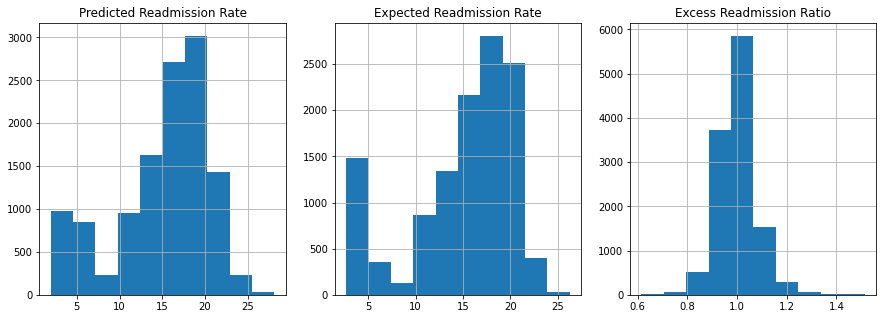

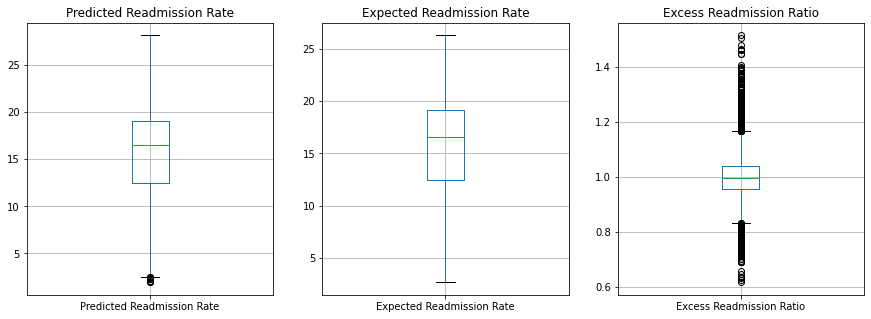

In [0]:
import matplotlib.pyplot as plt

# Convert to Pandas DataFrame for plotting
pdf = df_cleaned.select("Predicted Readmission Rate", "Expected Readmission Rate", "Excess Readmission Ratio").toPandas()


# Plot histograms
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
pdf["Predicted Readmission Rate"].hist(ax=axs[0])
axs[0].set_title("Predicted Readmission Rate")
pdf["Expected Readmission Rate"].hist(ax=axs[1])
axs[1].set_title("Expected Readmission Rate")
pdf["Excess Readmission Ratio"].hist(ax=axs[2])
axs[2].set_title("Excess Readmission Ratio")

plt.show()

# Plot box plots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
pdf.boxplot(column="Predicted Readmission Rate", ax=axs[0])
axs[0].set_title("Predicted Readmission Rate")
pdf.boxplot(column="Expected Readmission Rate", ax=axs[1])
axs[1].set_title("Expected Readmission Rate")
pdf.boxplot(column="Excess Readmission Ratio", ax=axs[2])
axs[2].set_title("Excess Readmission Ratio")

plt.show()


In [0]:
# Interpretation of the Plots
# Histogram Interpretation:

#     Predicted Readmission Rate:
#         Most predicted readmission rates fall between 10 and 20, with a peak around 18.
#         There are fewer instances of predicted readmission rates below 10 and above 25.

#     Expected Readmission Rate:
#         The expected readmission rates have a similar distribution to the predicted rates, concentrated between 10 and 20.
#         The peak is slightly lower than the predicted readmission rates, around 15.

#     Excess Readmission Ratio:
#         The excess readmission ratio is centered around 1.0, indicating that most hospitals have an actual readmission rate close to the expected rate.
#         There are fewer hospitals with ratios significantly above or below 1.0, indicating fewer outliers.

# Box Plot Interpretation:

#     Predicted Readmission Rate:
#         The median predicted readmission rate is around 16.
#         There are some outliers below 5.

#     Expected Readmission Rate:
#         The median expected readmission rate is around 16.
#         The distribution is slightly tighter compared to the predicted readmission rate.

#     Excess Readmission Ratio:
#         The median ratio is 1.0, with a tighter interquartile range compared to the readmission rates.
#         There are significant outliers above and below the 1.0 ratio, indicating variability in performance compared to expectations.



In [0]:
df_cleaned.createOrReplaceTempView("hrrp")

query = """
SELECT State,
       SUM(`Number of Discharges`) AS total_admissions,
       SUM(`Number of Readmissions`) AS total_readmissions,
       ROUND((SUM(`Number of Readmissions`) * 100.0) / SUM(`Number of Discharges`),2) AS readmission_rate
FROM hrrp
GROUP BY State
ORDER BY readmission_rate DESC
"""

spark.sql(query).show()


+-----+----------------+------------------+----------------+
|State|total_admissions|total_readmissions|readmission_rate|
+-----+----------------+------------------+----------------+
|   WV|         17009.0|            3297.0|           19.38|
|   NV|         14849.0|            2826.0|           19.03|
|   DC|          5195.0|             988.0|           19.02|
|   MI|         65619.0|           12321.0|           18.78|
|   KY|         36371.0|            6655.0|            18.3|
|   VT|          3759.0|             679.0|           18.06|
|   GA|         50830.0|            9153.0|           18.01|
|   MS|         26433.0|            4744.0|           17.95|
|   IL|        101924.0|           18242.0|            17.9|
|   CA|        142377.0|           25452.0|           17.88|
|   LA|         25614.0|            4569.0|           17.84|
|   NJ|         68473.0|           12208.0|           17.83|
|   FL|        160233.0|           28544.0|           17.81|
|   OH|         76365.0|

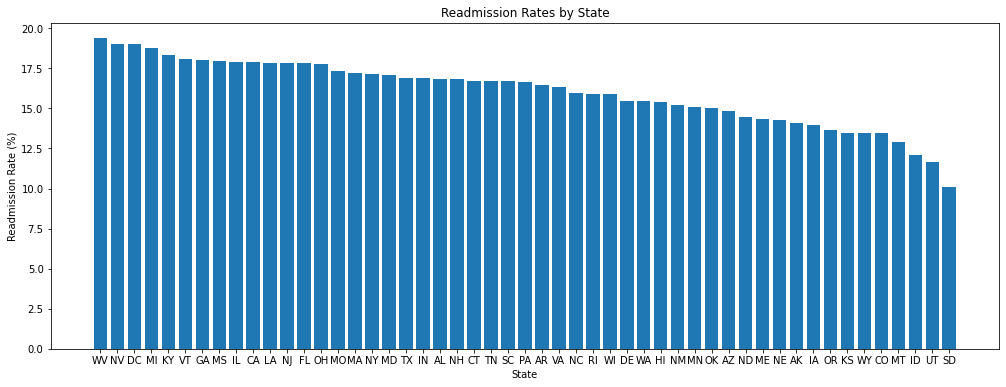

In [0]:
import matplotlib.pyplot as plt

result = spark.sql(query)

result_pandas = result.toPandas()

plt.figure(figsize=(17, 6))
plt.bar(result_pandas['State'], result_pandas['readmission_rate'])
plt.xlabel('State')
plt.ylabel('Readmission Rate (%)')
plt.title('Readmission Rates by State')
plt.show()

In [0]:
query_measure = """
SELECT
    `Measure Name`,
    SUM(`Number of Discharges`) AS total_admissions,
    SUM(`Number of Readmissions`) AS total_readmissions,
    (SUM(`Number of Readmissions`) * 100.0) / SUM(`Number of Discharges`) AS readmission_rate
FROM
    hrrp
GROUP BY
    `Measure Name`
ORDER BY
    readmission_rate DESC
"""

result_measure = spark.sql(query_measure)
result_measure_pandas = result_measure.toPandas()



In [0]:
result_measure = spark.sql(query_measure).show()

+--------------------+----------------+------------------+------------------+
|        Measure Name|total_admissions|total_readmissions|  readmission_rate|
+--------------------+----------------+------------------+------------------+
|    READM-30-HF-HRRP|        735641.0|          148213.0| 20.14746323274532|
|  READM-30-COPD-HRRP|        195589.0|           39275.0| 20.08037261809202|
|    READM-30-PN-HRRP|        591846.0|          101169.0|17.093804807331637|
|   READM-30-AMI-HRRP|        239050.0|           33269.0|13.917172139719725|
|  READM-30-CABG-HRRP|         52742.0|            6177.0|11.711728792992302|
|READM-30-HIP-KNEE...|        162107.0|            6721.0| 4.146027006853498|
+--------------------+----------------+------------------+------------------+



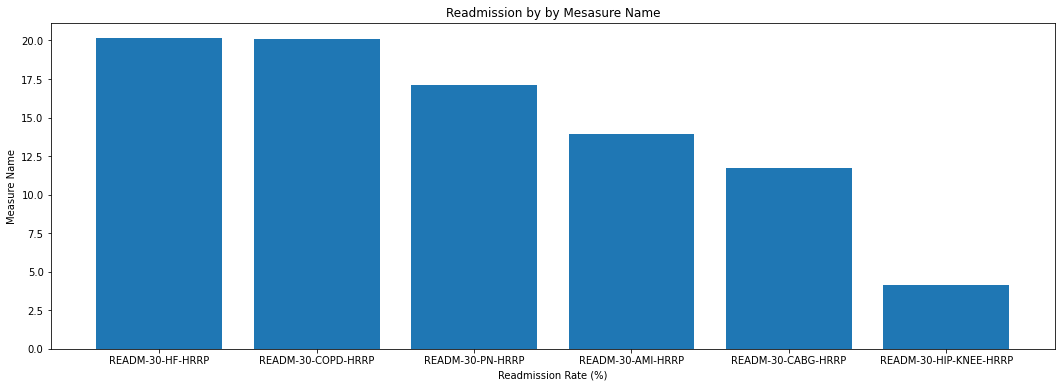

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
plt.bar(result_measure_pandas['Measure Name'], result_measure_pandas['readmission_rate'])
plt.xlabel('Readmission Rate (%)')
plt.ylabel('Measure Name')
plt.title('Readmission by by Mesasure Name')
plt.show()

In [0]:
query_facility = """
SELECT
    `Facility Name`,
    SUM(`Number of Discharges`) AS total_admissions,
    SUM(`Number of Readmissions`) AS total_readmissions,
    ROUND((SUM(`Number of Readmissions`) * 100.0) / SUM(`Number of Discharges`),2) AS readmission_rate
FROM
    hrrp
GROUP BY
    `Facility Name`
ORDER BY
    readmission_rate DESC
"""

result_facility = spark.sql(query_facility)
result_facility_pandas = result_facility.toPandas()


In [0]:
result_facility = spark.sql(query_facility).show()

+--------------------+----------------+------------------+----------------+
|       Facility Name|total_admissions|total_readmissions|readmission_rate|
+--------------------+----------------+------------------+----------------+
| ST BERNARD HOSPITAL|            52.0|              23.0|           44.23|
|EASTERN NIAGARA H...|            43.0|              17.0|           39.53|
|HUMBOLDT PARK HEALTH|            56.0|              22.0|           39.29|
|CAREPOINT HEALTH-...|            55.0|              20.0|           36.36|
|ROSELAND COMMUNIT...|            97.0|              34.0|           35.05|
|JACKSON PARK HOSP...|            54.0|              18.0|           33.33|
|WADLEY REGIONAL M...|            33.0|              11.0|           33.33|
|LARKIN COMMUNITY ...|            63.0|              21.0|           33.33|
|EAST CARROLL PARI...|            58.0|              19.0|           32.76|
|VICTOR VALLEY GLO...|           113.0|              37.0|           32.74|
|PERSON MEMO

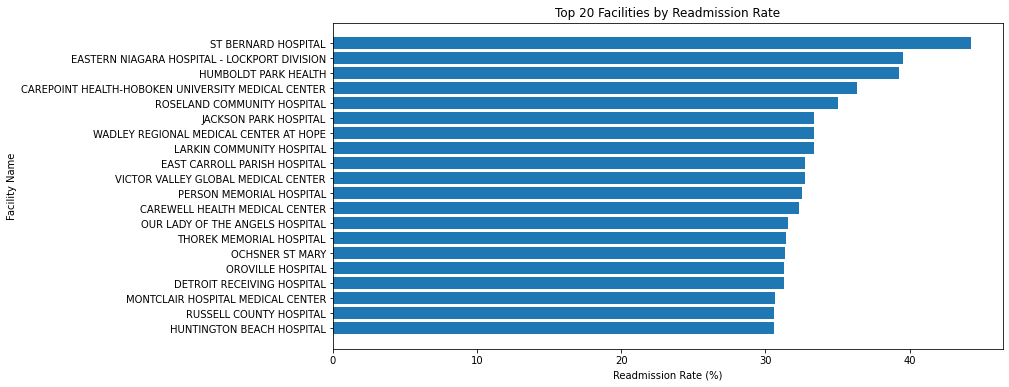

In [0]:
import matplotlib.pyplot as plt

# Select top 20 facilities by readmission rate
top_20_facilities = result_facility_pandas.head(20)

# Plotting the bar chart
plt.figure(figsize=(12, 6))
plt.barh(top_20_facilities['Facility Name'], top_20_facilities['readmission_rate'])
plt.xlabel('Readmission Rate (%)')
plt.ylabel('Facility Name')
plt.title('Top 20 Facilities by Readmission Rate')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest rate at the top
plt.show()


In [0]:
query_err = """
SELECT
    `Facility Name`,
    `State`,
    `Excess Readmission Ratio`,
    CASE
        WHEN `Excess Readmission Ratio` > 1 THEN 'Higher than Expected'
        WHEN `Excess Readmission Ratio` < 1 THEN 'Lower than Expected'
        ELSE 'As Expected'
    END AS `Readmission Performance`
FROM
    hrrp
ORDER BY
    `Excess Readmission Ratio` DESC
"""

result_err = spark.sql(query_err)
result_err_pandas = result_err.toPandas()


In [0]:
result_err = spark.sql(query_err).show()

+--------------------+-----+------------------------+-----------------------+
|       Facility Name|State|Excess Readmission Ratio|Readmission Performance|
+--------------------+-----+------------------------+-----------------------+
|ARIZONA ORTHOPEDI...|   AZ|                  1.5162|   Higher than Expected|
|LOUIS A WEISS MEM...|   IL|                  1.5076|   Higher than Expected|
|RESEARCH MEDICAL ...|   MO|                  1.4795|   Higher than Expected|
|BELTON REGIONAL M...|   MO|                  1.4671|   Higher than Expected|
|COMANCHE COUNTY M...|   OK|                  1.4636|   Higher than Expected|
|HCA FLORIDA OAK H...|   FL|                  1.4629|   Higher than Expected|
|CAPE FEAR VALLEY ...|   NC|                  1.4495|   Higher than Expected|
|   OROVILLE HOSPITAL|   CA|                   1.448|   Higher than Expected|
|NORTHEAST ALABAMA...|   AL|                  1.4087|   Higher than Expected|
|ST MARY MEDICAL C...|   CA|                  1.4016|   Higher t

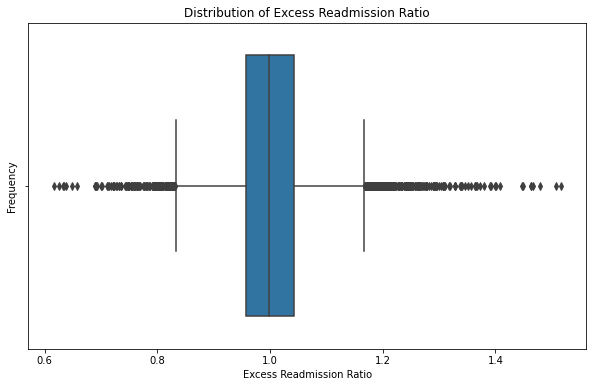

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=result_err_pandas, x='Excess Readmission Ratio')
plt.xlabel('Excess Readmission Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of Excess Readmission Ratio')
plt.show()


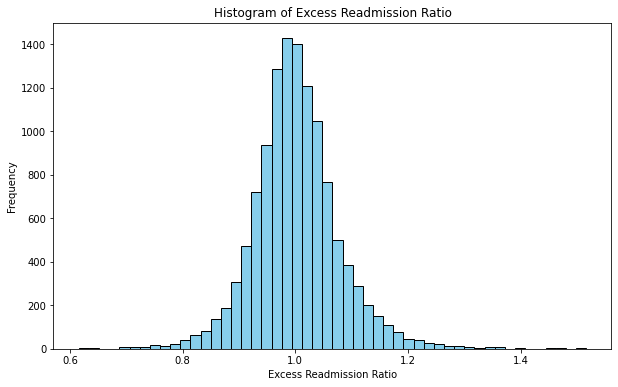

In [0]:
plt.figure(figsize=(10, 6))
plt.hist(result_err_pandas['Excess Readmission Ratio'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Excess Readmission Ratio')
plt.ylabel('Frequency')
plt.title('Histogram of Excess Readmission Ratio')
plt.show()


In [0]:
query_heatmap = """
SELECT
    `State`,
    AVG(`Excess Readmission Ratio`) AS avg_excess_readmission_ratio
FROM
    hrrp
GROUP BY
    `State`
ORDER BY
    avg_excess_readmission_ratio DESC
"""

result_heatmap = spark.sql(query_heatmap)
result_heatmap_pandas = result_heatmap.toPandas()


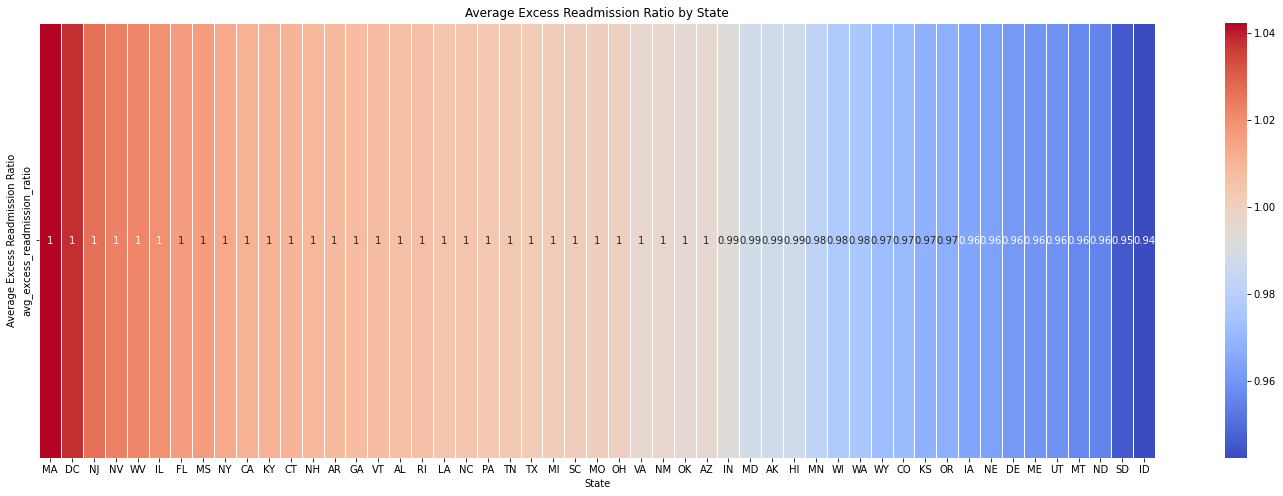

In [0]:
plt.figure(figsize=(25, 8))
sns.heatmap(result_heatmap_pandas.set_index('State').T, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Average Excess Readmission Ratio by State')
plt.xlabel('State')
plt.ylabel('Average Excess Readmission Ratio')
plt.show()


In [0]:
#  Predicted vs. Expected Readmission Rates

query_pred_exp = """
SELECT
    `Facility Name`,
    `State`,
    `Predicted Readmission Rate`,
    `Expected Readmission Rate`,
    `Predicted Readmission Rate` - `Expected Readmission Rate` AS difference
FROM
    hrrp
ORDER BY
    difference DESC
"""

result_pred_exp = spark.sql(query_pred_exp)
result_pred_exp_pandas = result_pred_exp.toPandas()


In [0]:
result_pred_exp = spark.sql(query_pred_exp).show()

+--------------------+-----+--------------------------+-------------------------+----------+
|       Facility Name|State|Predicted Readmission Rate|Expected Readmission Rate|difference|
+--------------------+-----+--------------------------+-------------------------+----------+
|   OROVILLE HOSPITAL|   CA|                   25.2946|                  17.4682|  7.826399|
|   OROVILLE HOSPITAL|   CA|                   26.6684|                   19.528|    7.1404|
|ST LUCIE MEDICAL ...|   FL|                   25.8605|                  19.7773| 6.0832005|
|WEST HILLS HOSPIT...|   CA|                   24.1727|                   19.407| 4.7657013|
|ALLIANCEHEALTH DU...|   OK|                   20.9963|                  16.4155|  4.580799|
|ECU HEALTH NORTH ...|   NC|                   25.2173|                  20.6904| 4.5269012|
|ADVENTHEALTH ORLANDO|   FL|                   16.6761|                   12.233|    4.4431|
|   OROVILLE HOSPITAL|   CA|                    25.301|               

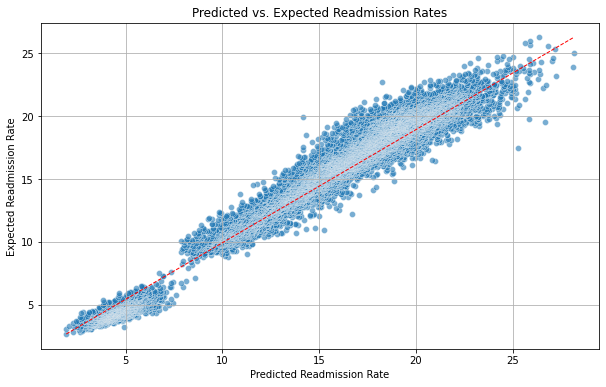

In [0]:
plt.figure(figsize=(10, 6))
plt.scatter(result_pred_exp_pandas['Predicted Readmission Rate'], result_pred_exp_pandas['Expected Readmission Rate'], alpha=0.6, edgecolors='w', linewidth=0.5)
plt.xlabel('Predicted Readmission Rate')
plt.ylabel('Expected Readmission Rate')
plt.title('Predicted vs. Expected Readmission Rates')
plt.plot([result_pred_exp_pandas['Predicted Readmission Rate'].min(), result_pred_exp_pandas['Predicted Readmission Rate'].max()],
         [result_pred_exp_pandas['Expected Readmission Rate'].min(), result_pred_exp_pandas['Expected Readmission Rate'].max()],
         color='red', linestyle='--', linewidth=1)
plt.grid(True)
plt.show()


In [0]:
#  Trend Analysis by Measure Name

query_pred_exp = """
SELECT
    `Measure Name`,
    AVG(`Excess Readmission Ratio`) AS Avg_excess_readmission_ratio
FROM
    hrrp
GROUP BY 
    `Measure Name`
ORDER BY
    Avg_excess_readmission_ratio DESC
"""

result_pred_exp = spark.sql(query_pred_exp).display()
# result_pred_exp_pandas = result_pred_exp.toPandas()


Measure Name,Avg_excess_readmission_ratio
READM-30-HIP-KNEE-HRRP,1.0041614797156835
READM-30-AMI-HRRP,1.001786358078693
READM-30-COPD-HRRP,1.0015292598631071
READM-30-PN-HRRP,1.001242992878835
READM-30-HF-HRRP,1.0011129786212711
READM-30-CABG-HRRP,1.001046437778692


Databricks visualization. Run in Databricks to view.

In [0]:
# Correlation analysis 

spark.sql("""CREATE OR REPLACE TEMP VIEW hrrp_numeric AS 

SELECT
    `Number of Discharges`,
    `Excess Readmission Ratio`,
    `Predicted Readmission Rate`,
    `Expected Readmission Rate`,
    `Number of Readmissions`
FROM hrrp """)


query_corr_analysis = """
SELECT
    corr(`Number of Discharges`, `Excess Readmission Ratio`) AS corr_num_dis_excess_read_ratio,
    corr(`Number of Discharges`, `Predicted Readmission Rate`) AS corr_num_dis_pred_read_rate,
    corr(`Number of Discharges`, `Expected Readmission Rate`) AS corr_num_dis_exp_read_rate,
    corr(`Number of Discharges`, `Number of Readmissions`) AS corr_num_dis_num_read,
    corr(`Excess Readmission Ratio`, `Predicted Readmission Rate`) AS corr_excess_read_ratio_pred_read_rate,
    corr(`Excess Readmission Ratio`, `Expected Readmission Rate`) AS corr_excess_read_ratio_exp_read_rate,
    corr(`Excess Readmission Ratio`, `Number of Readmissions`) AS corr_excess_read_ratio_num_read,
    corr(`Predicted Readmission Rate`, `Expected Readmission Rate`) AS corr_pred_read_rate_exp_read_rate,
    corr(`Predicted Readmission Rate`, `Number of Readmissions`) AS corr_pred_read_rate_num_read,
    corr(`Expected Readmission Rate`, `Number of Readmissions`) AS corr_exp_read_rate_num_read
FROM hrrp_numeric
"""

result_corr = spark.sql(query_corr_analysis)
result_corr_pd = result_corr.toPandas()

In [0]:

result_corr.display()

corr_num_dis_excess_read_ratio,corr_num_dis_pred_read_rate,corr_num_dis_exp_read_rate,corr_num_dis_num_read,corr_excess_read_ratio_pred_read_rate,corr_excess_read_ratio_exp_read_rate,corr_excess_read_ratio_num_read,corr_pred_read_rate_exp_read_rate,corr_pred_read_rate_num_read,corr_exp_read_rate_num_read
-0.14820601472297132,-0.08438756965671781,-0.06153485682131088,0.8486803666930173,0.17397611094996335,0.012194509811765172,0.08526646292430239,0.9825342726641431,0.301085635570958,0.2783784728418147


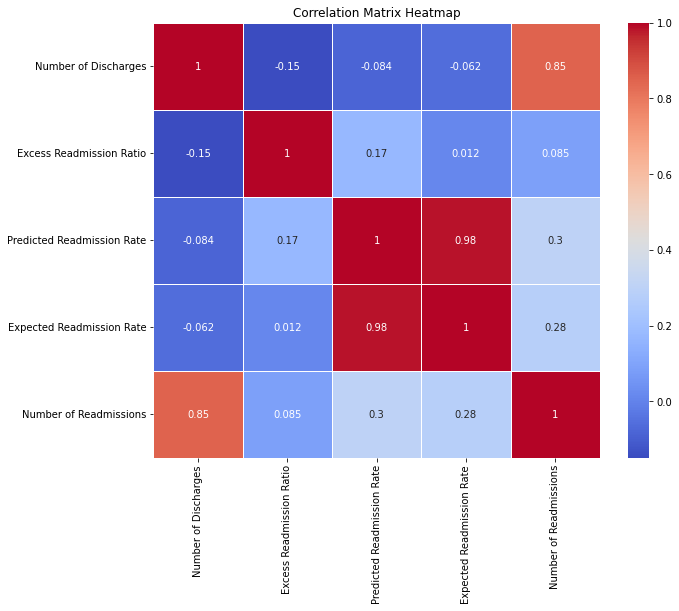

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define the correlation matrix based on the query results
correlation_data = {
    'Number of Discharges': [1,
                             result_corr_pd['corr_num_dis_excess_read_ratio'][0],
                             result_corr_pd['corr_num_dis_pred_read_rate'][0],
                             result_corr_pd['corr_num_dis_exp_read_rate'][0],
                             result_corr_pd['corr_num_dis_num_read'][0]],
    'Excess Readmission Ratio': [result_corr_pd['corr_num_dis_excess_read_ratio'][0], 
                                 1, 
                                 result_corr_pd['corr_excess_read_ratio_pred_read_rate'][0],
                                 result_corr_pd['corr_excess_read_ratio_exp_read_rate'][0],
                                 result_corr_pd['corr_excess_read_ratio_num_read'][0]],
    'Predicted Readmission Rate': [result_corr_pd['corr_num_dis_pred_read_rate'][0], 
                                   result_corr_pd['corr_excess_read_ratio_pred_read_rate'][0], 
                                   1,
                                   result_corr_pd['corr_pred_read_rate_exp_read_rate'][0],
                                   result_corr_pd['corr_pred_read_rate_num_read'][0]],
    'Expected Readmission Rate': [result_corr_pd['corr_num_dis_exp_read_rate'][0], 
                                  result_corr_pd['corr_excess_read_ratio_exp_read_rate'][0], 
                                  result_corr_pd['corr_pred_read_rate_exp_read_rate'][0],
                                  1,
                                  result_corr_pd['corr_exp_read_rate_num_read'][0]],
    'Number of Readmissions': [result_corr_pd['corr_num_dis_num_read'][0], 
                               result_corr_pd['corr_excess_read_ratio_num_read'][0], 
                               result_corr_pd['corr_pred_read_rate_num_read'][0],
                               result_corr_pd['corr_exp_read_rate_num_read'][0],
                               1]
}

correlation_df = pd.DataFrame(correlation_data, index=[
    'Number of Discharges', 'Excess Readmission Ratio', 'Predicted Readmission Rate', 'Expected Readmission Rate', 'Number of Readmissions'
])

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


In [0]:
# -- Calculate the correlation coefficients and store the results in a temporary view
spark.sql("""CREATE OR REPLACE TEMP VIEW hrrp_correlation AS
SELECT
    'Number of Discharges' AS variable,
    corr(`Number of Discharges`, `Excess Readmission Ratio`) AS corr_excess_read_ratio,
    corr(`Number of Discharges`, `Predicted Readmission Rate`) AS corr_pred_read_rate,
    corr(`Number of Discharges`, `Expected Readmission Rate`) AS corr_exp_read_rate,
    corr(`Number of Discharges`, `Number of Readmissions`) AS corr_num_read
FROM hrrp
UNION ALL
SELECT
    'Excess Readmission Ratio' AS variable,
    corr(`Excess Readmission Ratio`, `Number of Discharges`),
    corr(`Excess Readmission Ratio`, `Predicted Readmission Rate`),
    corr(`Excess Readmission Ratio`, `Expected Readmission Rate`),
    corr(`Excess Readmission Ratio`, `Number of Readmissions`)
FROM hrrp
UNION ALL
SELECT
    'Predicted Readmission Rate' AS variable,
    corr(`Predicted Readmission Rate`, `Number of Discharges`),
    corr(`Predicted Readmission Rate`, `Excess Readmission Ratio`),
    corr(`Predicted Readmission Rate`, `Expected Readmission Rate`),
    corr(`Predicted Readmission Rate`, `Number of Readmissions`)
FROM hrrp
UNION ALL
SELECT
    'Expected Readmission Rate' AS variable,
    corr(`Expected Readmission Rate`, `Number of Discharges`),
    corr(`Expected Readmission Rate`, `Excess Readmission Ratio`),
    corr(`Expected Readmission Rate`, `Predicted Readmission Rate`),
    corr(`Expected Readmission Rate`, `Number of Readmissions`)
FROM hrrp
UNION ALL
SELECT
    'Number of Readmissions' AS variable,
    corr(`Number of Readmissions`, `Number of Discharges`),
    corr(`Number of Readmissions`, `Excess Readmission Ratio`),
    corr(`Number of Readmissions`, `Predicted Readmission Rate`),
    corr(`Number of Readmissions`, `Expected Readmission Rate`)
FROM hrrp """)


Out[46]: DataFrame[]

In [0]:
result_corr = spark.sql("SELECT * FROM hrrp_correlation")
print(result_corr_pd.columns)
result_corr_pd = result_corr.toPandas()


Index(['corr_num_dis_excess_read_ratio', 'corr_num_dis_pred_read_rate',
       'corr_num_dis_exp_read_rate', 'corr_num_dis_num_read',
       'corr_excess_read_ratio_pred_read_rate',
       'corr_excess_read_ratio_exp_read_rate',
       'corr_excess_read_ratio_num_read', 'corr_pred_read_rate_exp_read_rate',
       'corr_pred_read_rate_num_read', 'corr_exp_read_rate_num_read'],
      dtype='object')


In [0]:
result_corr = spark.sql("SELECT * FROM hrrp_correlation").show()

+--------------------+----------------------+--------------------+--------------------+-------------------+
|            variable|corr_excess_read_ratio| corr_pred_read_rate|  corr_exp_read_rate|      corr_num_read|
+--------------------+----------------------+--------------------+--------------------+-------------------+
|Number of Discharges|  -0.14820601472297132|-0.08438756965671781|-0.06153485682131088| 0.8486803666930173|
|Excess Readmissio...|  -0.14820601472297135| 0.17397611094996335|0.012194509811765172|0.08526646292430239|
|Predicted Readmis...|  -0.08438756965671779| 0.17397611094996351|  0.9825342726641431|  0.301085635570958|
|Expected Readmiss...|  -0.06153485682131086|0.012194509811765194|  0.9825342726641431| 0.2783784728418147|
|Number of Readmis...|    0.8486803666930173| 0.08526646292430227|   0.301085635570958| 0.2783784728418148|
+--------------------+----------------------+--------------------+--------------------+-------------------+



In [0]:
import matplotlib.pyplot as plt

# Reshape the DataFrame to a square matrix format
correlation_matrix = correlation_df.pivot(index='variable', columns='variable')

plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()

# Set ticks and labels
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.index)

plt.title('Correlation Matrix Heatmap')
plt.show()



---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
File <command-2700968355221020>:4
      1 import matplotlib.pyplot as plt
      3 # Reshape the DataFrame to a square matrix format
----> 4 correlation_matrix = correlation_df.pivot(index='variable', columns='variable')
      6 plt.figure(figsize=(10, 8))
      7 plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')

File /databricks/python/lib/python3.9/site-packages/pandas/core/frame.py:7876, in DataFrame.pivot(self, index, columns, values)
   7871 @Substitution("")
   7872 @Appender(_shared_docs["pivot"])
   7873 def pivot(self, index=None, columns=None, values=None) -> DataFrame:
   7874     from pandas.core.reshape.pivot import pivot
-> 7876     return pivot(self, index=index, columns=columns, values=values)

File /databricks/python/lib/python3.9/site-packages/pandas/core/reshape/pivot.py:493, in pivot(data, index, 

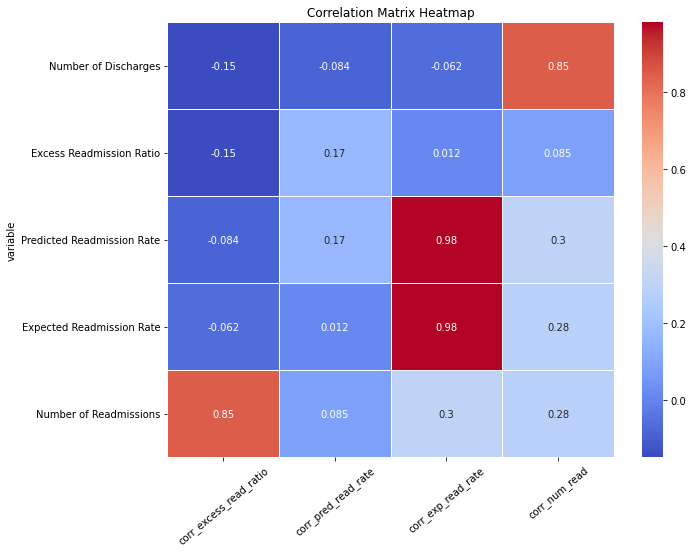

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure the column names are correct
correlation_data = result_corr_pd.set_index('variable')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=40)
plt.yticks(rotation=0)
plt.show()


In [0]:
spark.sql("""
CREATE OR REPLACE TEMP VIEW hrrp_correlation AS
SELECT
    'Number of Discharges' AS variable1,
    'Excess Readmission Ratio' AS variable2,
    corr(`Number of Discharges`, `Excess Readmission Ratio`) AS correlation
FROM hrrp
UNION ALL
SELECT
    'Number of Discharges', 'Predicted Readmission Rate', corr(`Number of Discharges`, `Predicted Readmission Rate`)
FROM hrrp
UNION ALL
SELECT
    'Number of Discharges', 'Expected Readmission Rate', corr(`Number of Discharges`, `Expected Readmission Rate`)
FROM hrrp
UNION ALL
SELECT
    'Number of Discharges', 'Number of Readmissions', corr(`Number of Discharges`, `Number of Readmissions`)
FROM hrrp
UNION ALL
SELECT
    'Excess Readmission Ratio', 'Number of Discharges', corr(`Excess Readmission Ratio`, `Number of Discharges`)
FROM hrrp
UNION ALL
SELECT
    'Excess Readmission Ratio', 'Predicted Readmission Rate', corr(`Excess Readmission Ratio`, `Predicted Readmission Rate`)
FROM hrrp
UNION ALL
SELECT
    'Excess Readmission Ratio', 'Expected Readmission Rate', corr(`Excess Readmission Ratio`, `Expected Readmission Rate`)
FROM hrrp
UNION ALL
SELECT
    'Excess Readmission Ratio', 'Number of Readmissions', corr(`Excess Readmission Ratio`, `Number of Readmissions`)
FROM hrrp
UNION ALL
SELECT
    'Predicted Readmission Rate', 'Number of Discharges', corr(`Predicted Readmission Rate`, `Number of Discharges`)
FROM hrrp
UNION ALL
SELECT
    'Predicted Readmission Rate', 'Excess Readmission Ratio', corr(`Predicted Readmission Rate`, `Excess Readmission Ratio`)
FROM hrrp
UNION ALL
SELECT
    'Predicted Readmission Rate', 'Expected Readmission Rate', corr(`Predicted Readmission Rate`, `Expected Readmission Rate`)
FROM hrrp
UNION ALL
SELECT
    'Predicted Readmission Rate', 'Number of Readmissions', corr(`Predicted Readmission Rate`, `Number of Readmissions`)
FROM hrrp
UNION ALL
SELECT
    'Expected Readmission Rate', 'Number of Discharges', corr(`Expected Readmission Rate`, `Number of Discharges`)
FROM hrrp
UNION ALL
SELECT
    'Expected Readmission Rate', 'Excess Readmission Ratio', corr(`Expected Readmission Rate`, `Excess Readmission Ratio`)
FROM hrrp
UNION ALL
SELECT
    'Expected Readmission Rate', 'Predicted Readmission Rate', corr(`Expected Readmission Rate`, `Predicted Readmission Rate`)
FROM hrrp
UNION ALL
SELECT
    'Expected Readmission Rate', 'Number of Readmissions', corr(`Expected Readmission Rate`, `Number of Readmissions`)
FROM hrrp
UNION ALL
SELECT
    'Number of Readmissions', 'Number of Discharges', corr(`Number of Readmissions`, `Number of Discharges`)
FROM hrrp
UNION ALL
SELECT
    'Number of Readmissions', 'Excess Readmission Ratio', corr(`Number of Readmissions`, `Excess Readmission Ratio`)
FROM hrrp
UNION ALL
SELECT
    'Number of Readmissions', 'Predicted Readmission Rate', corr(`Number of Readmissions`, `Predicted Readmission Rate`)
FROM hrrp
UNION ALL
SELECT
    'Number of Readmissions', 'Expected Readmission Rate', corr(`Number of Readmissions`, `Expected Readmission Rate`)
FROM hrrp
""")


Out[51]: DataFrame[]

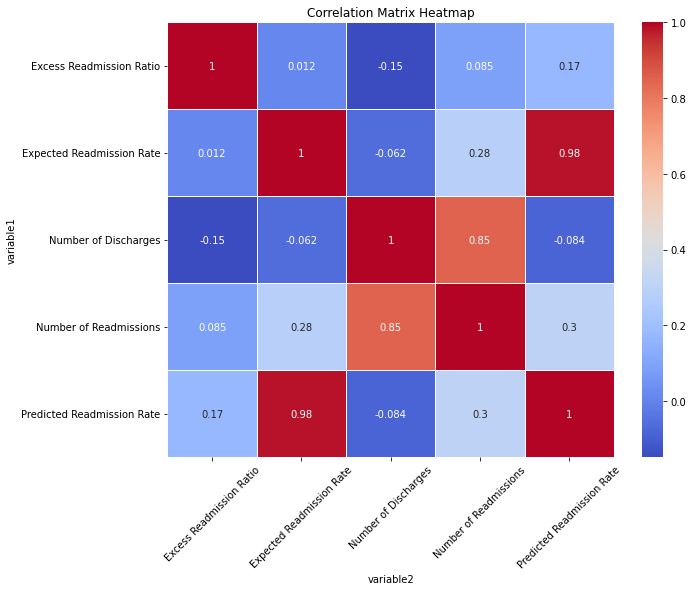

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Fetch the correlation data from the temporary view
correlation_data = spark.sql("SELECT * FROM hrrp_correlation").toPandas()

# Create a pivot table to get a square matrix
correlation_matrix = correlation_data.pivot(index='variable1', columns='variable2', values='correlation')

# Fill the diagonal with 1s since the correlation of a variable with itself is 1
for column in correlation_matrix.columns:
    correlation_matrix.at[column, column] = 1

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()
